In [2]:
import os
import json
import argparse
import torch
import random
import numpy as np
from pathlib import Path
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
#from model.FFTRadNet import FFTRadNet
from valeo_dataset.dataset import RADIal
from valeo_dataset.encoder import ra_encoder
from valeo_dataset.dataloader import CreateDataLoaders,ReturnIdsForTrainTestVal
import pkbar
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
#from loss import pixor_loss
#from utils.evaluation import run_evaluation
import torch.nn as nn

from matplotlib import pyplot as plt
from matplotlib import gridspec
plt.style.use('default')
import pandas as pd
from DBReader import SyncReader
from scipy.interpolate import interp2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Getmostrecentodometry import Own_GetMostRecentOdometry,Get_RadarVelocityInVehCS
from SensorsReaders import CANDecoder
from rpl import RadarSignalProcessing
import cv2
import polarTransform
from PIL import Image
from torchvision.transforms import Resize,CenterCrop
import torchvision.transforms as transform
from util import *

In [3]:
config = os.path.join('valeo_dataset/','config_FFTRadNet_192_56.json')
try:
    config = json.load(open(config))
    config['dataset']['root_dir'] = '/home/yi/work/valeo_dataset/RADIal/'
except FileNotFoundError:
    print('fail to laod json config')    

In [4]:
root_dir = config['dataset']['root_dir']
labels = pd.read_csv(os.path.join(root_dir,'labels.csv')).to_numpy()
# Gather each input entries by their sample id
unique_ids = np.unique(labels[:,0])
label_dict = {}
for i,ids in enumerate(unique_ids):
    sample_ids = np.where(labels[:,0]==ids)[0]
    label_dict[ids]=sample_ids
sample_keys = list(label_dict.keys())
# Load the camera calibration parameters
calib = np.load('camera_calib.npy',allow_pickle=True).item()

In [5]:
 # Load the dataset
enc = ra_encoder(geometry = config['dataset']['geometry'], 
                statistics = config['dataset']['statistics'],
                regression_layer = 2)

dataset = RADIal(root_dir = config['dataset']['root_dir'],
                statistics= config['dataset']['statistics'],
                encoder=enc.encode,
                difficult=True)

train_loader, val_loader, test_loader = CreateDataLoaders(dataset,config['dataloader'],config['seed'])
train_ids, val_ids, test_ids = ReturnIdsForTrainTestVal(dataset,config['dataloader'],config['seed'])
radar_h = 0.8 # m
lidar_h = 0.42 # m


===========  Dataset  ==================:
      Mode: sequence
      Training: 6231
      Validation: 986
      Test: 1035



In [57]:
sample_keys[0] 

18

In [59]:
train_ids[0:5] 

array([0, 1, 2, 3, 4])

In [ ]:
sample_keys

-------------------------------------------------------------------------
- Sensors available:
-     radar_ch3
-     scala
-     radar_ch2
-     can
-     radar_ch0
-     camera
-     radar_ch1
-     gps
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.0 %
Total corrupted frames:  3.4482758620689653 %


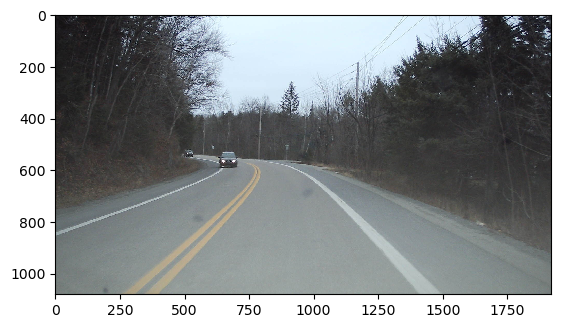

In [13]:
idx = 5

trace_name = labels[label_dict[sample_keys[idx]][0],-3] 
select_idx_in_trace = labels[label_dict[sample_keys[idx]][0],-2]
root_folder = os.path.join('/home/yi/work/valeo_dataset/RADIal/',trace_name)
### Open the dataset
current_db = SyncReader(root_folder)
# you need to provide the dbc decoder
can_decoder = CANDecoder('can_database.dbc')
current_data = current_db.GetSensorData(select_idx_in_trace)
current_timestamp = current_data['radar_ch0']['timestamp']  
current_odometry = Own_GetMostRecentOdometry(current_db,can_decoder,current_timestamp) # speed,yaw rate, steering wheel angle
current_radarvelocity = Get_RadarVelocityInVehCS(current_odometry)
plt.imshow(current_data['camera']['data'][:,:,-1::-1]   )#bgr2rgb

CPU will be used to execute the processing
CPU times: user 616 ms, sys: 130 ms, total: 746 ms
Wall time: 216 ms


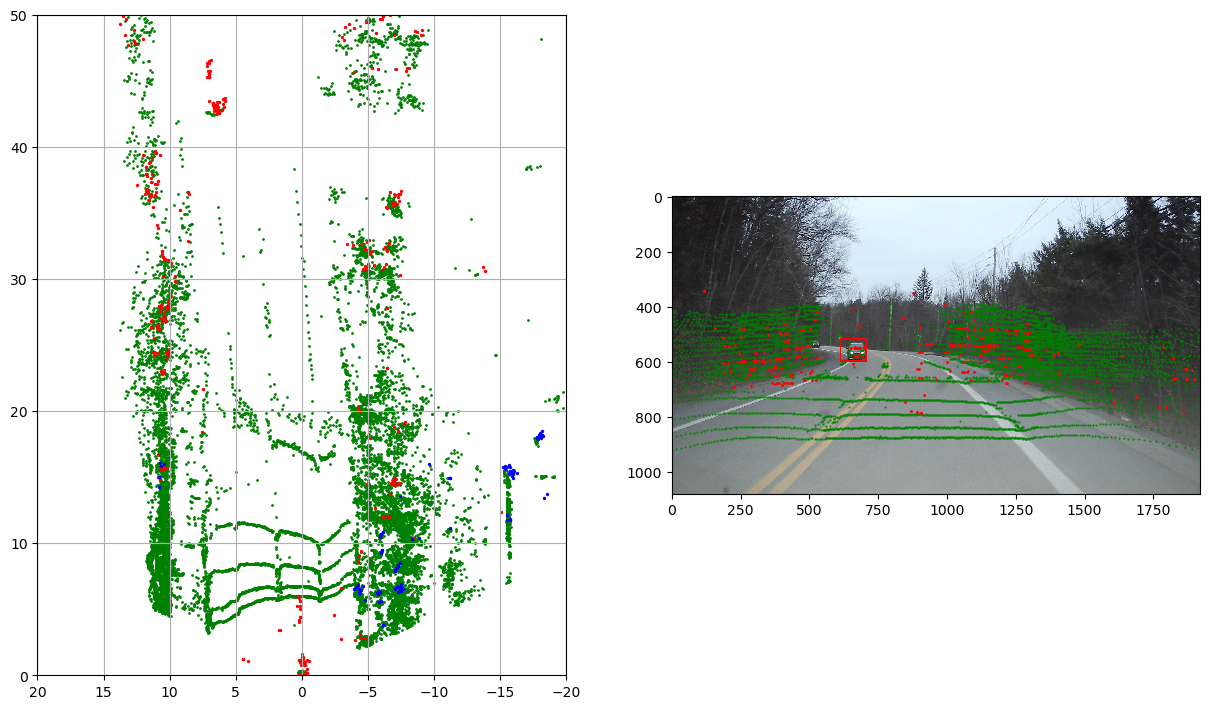

In [25]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='PC')
%time pc=RSP.run(current_data['radar_ch0']['data'],current_data['radar_ch1']['data'],current_data['radar_ch2']['data'],current_data['radar_ch3']['data'])
Az = pc[:,2] # +|- vehicel C.S. rad
R = pc[:,0]
El = pc[:,3] #up(+)0down(-), rad
Do = pc[:,1] 
#doppler shift
#0-127|128-255 
doppler_resolution = 0.1#m/s
num_doppler_bin = 256
posi_doppler_axis = doppler_resolution*np.arange(num_doppler_bin/2)
negi_doppler_axis = -1*doppler_resolution*np.arange(num_doppler_bin/2,0,-1)
doppler_axis_mps = np.concatenate((negi_doppler_axis.reshape(-1,1),posi_doppler_axis.reshape(-1,1)),axis=0)
doppler_axis_mps = doppler_axis_mps.reshape(-1,)
posi_side = np.where(Do<num_doppler_bin/2)[0]
negi_side = np.where(Do>=num_doppler_bin/2)[0]
Do_shift = np.copy(Do)
Do_shift[posi_side]  = Do_shift[posi_side] + num_doppler_bin/2
Do_shift[negi_side]  = Do_shift[negi_side] - num_doppler_bin/2
Do_shift = np.array(Do_shift,dtype=int)

vel_threshold = 1.5 #m/s
moving_sign = np.abs(doppler_axis_mps[Do_shift]*np.cos(El)+ current_radarvelocity[0]*np.cos(Az)+current_radarvelocity[1]*np.sin(Az))> vel_threshold
doppler_com = (doppler_axis_mps[Do_shift]+ current_radarvelocity[0]*np.cos(Az)+current_radarvelocity[1]*np.sin(Az))*moving_sign.astype(int)#approach -,leave +

pts = current_data['scala']['data']
fig=plt.figure(figsize=(15,15))
plt.tight_layout()
ax1=fig.add_subplot(121)
ax1.set_aspect('equal')
plt.scatter(pts[:,1],pts[:,0],s=1,color='green')#pts: x,y (Veh C.S.)

plt.xlim(20,-20)
plt.ylim(0,50)


plt.grid()
plt.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red')
plt.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue')

ax2 = fig.add_subplot(122)
cam_img = current_data['camera']['data']
## show bounding box
for idx_bbox in range(len(dataset[idx][3][:,6])):
    cam_img = cv2.rectangle(cam_img, (int(dataset[idx][3][:,6][idx_bbox]) ,int(dataset[idx][3][:,7][idx_bbox])),\
     (int(dataset[idx][3][:,8][idx_bbox]),int(dataset[idx][3][:,9][idx_bbox])), (0, 0, 255), 3)

ax2.imshow(cam_img[:,:,-1::-1])

# Now, we can project 3D points into the camera space
lidar_pts_compenstate = ConpensateLayerAngle(np.copy(pts),current_data['scala']['sample_number'],lidar_h)[:,:3]
lidar_pts_compenstate[:,[0, 1, 2]] = lidar_pts_compenstate[:,[1, 0,2]] # Swap the order
lidar_pts_compenstate[:,0]*=-1 # Left is positive

lidar_imgpts, _ = cv2.projectPoints(np.array(lidar_pts_compenstate), 
                              calib['extrinsic']['rotation_vector'], 
                              calib['extrinsic']['translation_vector'],
                              calib['intrinsic']['camera_matrix'],
                              calib['intrinsic']['distortion_coefficients'])

lidar_imgpts=lidar_imgpts.squeeze(1).astype('int')



radar_pts_cartesian = np.concatenate(((R*np.cos(Az)*np.cos(El)).reshape(-1,1),
    (R*np.sin(Az)*np.cos(El)).reshape(-1,1),(R*np.sin(El)+radar_h).reshape(-1,1)),axis=1)
radar_pts_cartesian[:,[0, 1, 2]] = radar_pts_cartesian[:,[1, 0,2]] # Swap the order
radar_pts_cartesian[:,0]*=-1 # Left is positive

radar_imgpts, _ = cv2.projectPoints(np.array(radar_pts_cartesian ), 
                              calib['extrinsic']['rotation_vector'], 
                              calib['extrinsic']['translation_vector'],
                              calib['intrinsic']['camera_matrix'],
                              calib['intrinsic']['distortion_coefficients'])

radar_imgpts=radar_imgpts.squeeze(1).astype('int')    

# Keep only points inside the image size
lidar_pt_idx = np.where( (lidar_imgpts[:,0]>=0) & (lidar_imgpts[:,0]<cam_img.shape[1]) & (lidar_imgpts[:,1]>=0) & (lidar_imgpts[:,1]<cam_img.shape[0]))[0]
radar_pt_withinImg_mask = (radar_imgpts[:,0]>=0) & (radar_imgpts[:,0]<cam_img.shape[1]) & (radar_imgpts[:,1]>=0) & (radar_imgpts[:,1]<cam_img.shape[0])
#filter unvalid
radar_pt_withinImg_mask = np.logical_and(radar_pt_withinImg_mask,R>5)#

plt.plot(lidar_imgpts[lidar_pt_idx,0],lidar_imgpts[lidar_pt_idx,1],'g.',markersize=1)
plt.plot(radar_imgpts[np.logical_and(radar_pt_withinImg_mask,moving_sign==1),0],radar_imgpts[np.logical_and(radar_pt_withinImg_mask,moving_sign==1),1],'r.',markersize=2)
plt.plot(radar_imgpts[np.logical_and(radar_pt_withinImg_mask,moving_sign==0),0],radar_imgpts[np.logical_and(radar_pt_withinImg_mask,moving_sign==0),1],'b.',markersize=2)

PyTorch on GPU will be used to execute the processing
CPU times: user 404 ms, sys: 156 ms, total: 560 ms
Wall time: 321 ms


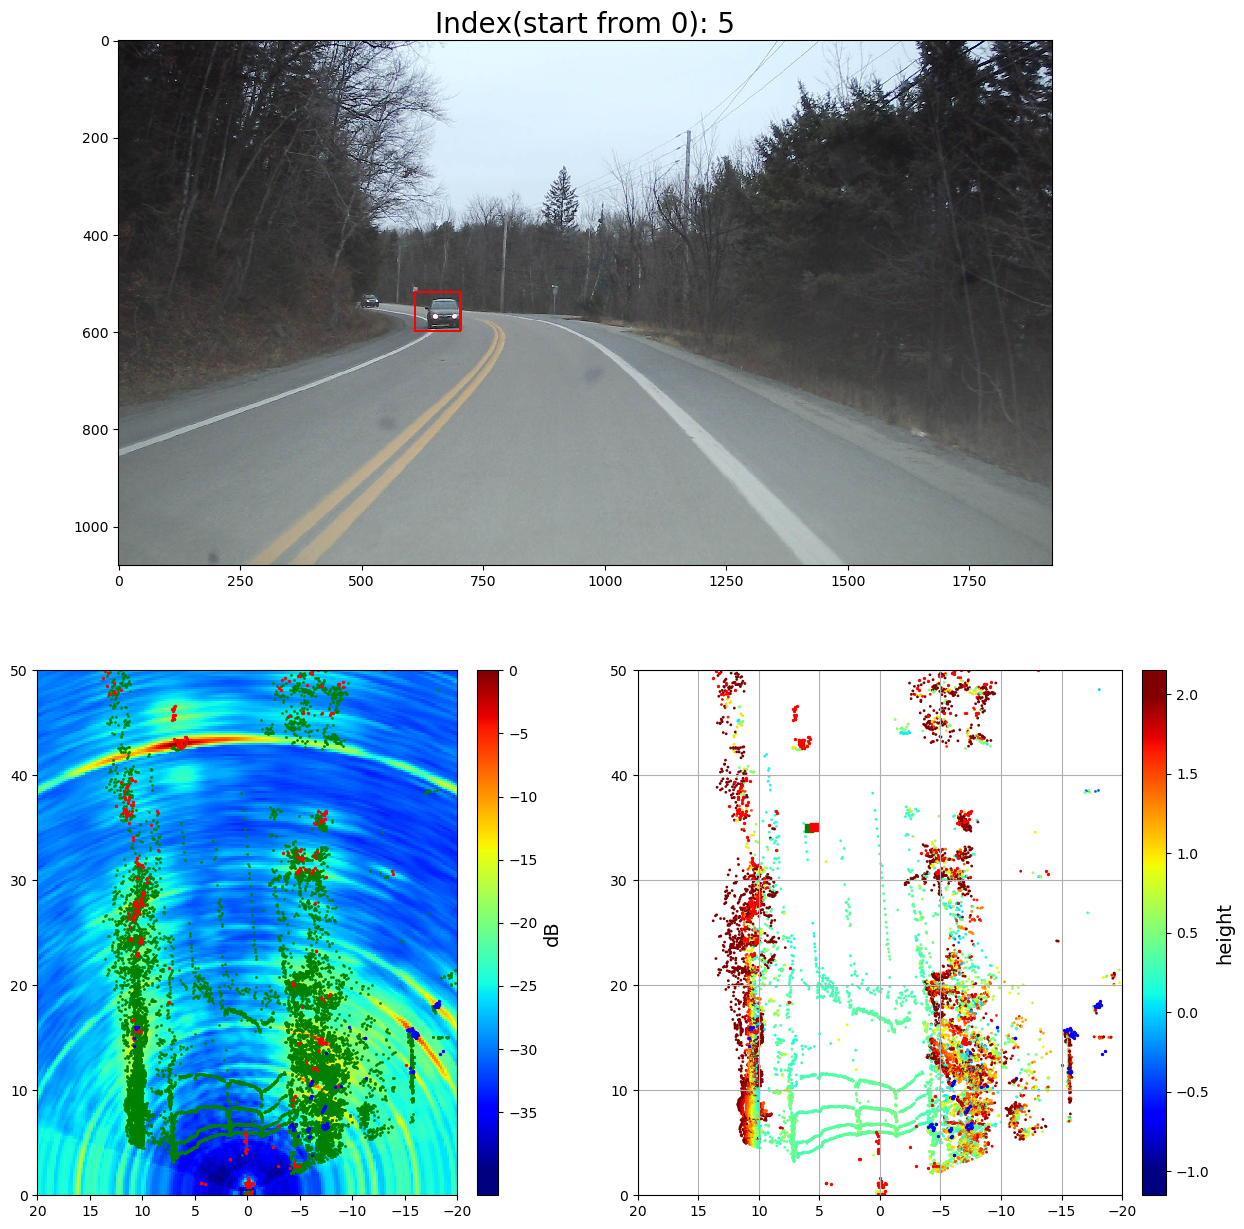

In [56]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')

%time ra=RSP.run(current_data['radar_ch0']['data'],current_data['radar_ch1']['data'],current_data['radar_ch2']['data'],current_data['radar_ch3']['data'])

Num_R_Bin = 512
AoA_mat = np.load('CalibrationTable.npy',allow_pickle=True).item()
sin_azi_axis = np.sin(np.deg2rad(AoA_mat['Azimuth_table'])) #deg
r_axis = np.arange(Num_R_Bin)/Num_R_Bin*103.
cellsize = 0.2
x_veh_lim = 50
y_veh_lim = 20

x_veh = np.arange(x_veh_lim,0-cellsize,-cellsize)
y_veh = np.arange(y_veh_lim,-y_veh_lim-cellsize,-cellsize)
y_veh_mesh,x_veh_mesh = np.meshgrid(y_veh,x_veh)
##RA Cartesian
r_veh_mesh = np.sqrt(np.square(x_veh_mesh)+np.square(y_veh_mesh))
sin_azi_veh_mesh = y_veh_mesh/(r_veh_mesh+np.finfo(np.float32).eps)
F =interp2d(r_axis,sin_azi_axis,ra.T)
ra_cartesian =[]
r_veh_mesh = np.ravel(r_veh_mesh)
sin_azi_veh_mesh = np.ravel(sin_azi_veh_mesh)
for i in range(len(r_veh_mesh)):
    ra_cartesian.append(F(r_veh_mesh[i],sin_azi_veh_mesh[i]))
ra_cartesian = np.asarray(ra_cartesian).reshape(y_veh_mesh.shape[0],y_veh_mesh.shape[1]) 
ra_cartesian = np.fliplr(ra_cartesian)##because x ais is reversed


fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,2,width_ratios=[1,1],height_ratios=[1,1])
##1 img + boundingbox
ax1 = fig.add_subplot(gs[0,:] )
ax1.set_title(f'Index(start from 0): {idx}',fontsize=20)
cam_img = current_data['camera']['data']
#format as following [Range, Angle, Doppler,laser_X_m,laser_Y_m,laser_Z_m,x1_pix,y1_pix,x2_pix	,y2_pix]
for idx_bbox in range(len(dataset[idx][3][:,6])):
    cam_img = cv2.rectangle(cam_img, (int(dataset[idx][3][:,6][idx_bbox]) ,int(dataset[idx][3][:,7][idx_bbox])),\
     (int(dataset[idx][3][:,8][idx_bbox]),int(dataset[idx][3][:,9][idx_bbox])), (0, 0, 255), 3)
ax1.imshow(cam_img[:,:,-1::-1] )

##2 radar+lidar
ax = fig.add_subplot(gs[1,0] )
ax.set_xlim([y_veh_lim,-y_veh_lim] )
ax.set_ylim([0,x_veh_lim] )
ax.set_aspect('equal')
ra_cartesian_img = ax.imshow(20*np.log10(ra_cartesian/np.max(ra_cartesian)),
    vmax=0,zorder=0,cmap='jet',extent=[-y_veh_lim,y_veh_lim,0,x_veh_lim] )

#process radar point cloud
Az = pc[:,2] 
R = pc[:,0]
El = pc[:,3] 
Do = pc[:,1] 

pts = current_data['scala']['data']
pts = ConpensateLayerAngle(np.copy(pts),current_data['scala']['sample_number'],lidar_h)[:,:3]
#doppler shift
#0-127|128-255 
doppler_resolution = 0.1#m/s
num_doppler_bin = 256
posi_doppler_axis = doppler_resolution*np.arange(num_doppler_bin/2)
negi_doppler_axis = -1*doppler_resolution*np.arange(num_doppler_bin/2,0,-1)
doppler_axis_mps = np.concatenate((negi_doppler_axis.reshape(-1,1),posi_doppler_axis.reshape(-1,1)),axis=0)
doppler_axis_mps = doppler_axis_mps.reshape(-1,)
posi_side = np.where(Do<num_doppler_bin/2)[0]
negi_side = np.where(Do>=num_doppler_bin/2)[0]
Do_shift = np.copy(Do)
Do_shift[posi_side]  = Do_shift[posi_side] + num_doppler_bin/2
Do_shift[negi_side]  = Do_shift[negi_side] - num_doppler_bin/2
Do_shift = np.array(Do_shift,dtype=int)

vel_threshold = 1.5 #m/s
moving_sign = np.abs(doppler_axis_mps[Do_shift]*np.cos(El)+ 
    current_radarvelocity[0]*np.cos(Az)+current_radarvelocity[1]*np.sin(Az))> vel_threshold
doppler_com = (doppler_axis_mps[Do_shift]+ current_radarvelocity[0]*np.cos(Az)
    +current_radarvelocity[1]*np.sin(Az))*moving_sign.astype(int)#approach -,leave +

#det for lidar and radar
#lidar
plt.scatter(pts[:,1],pts[:,0],s=1,color='green',zorder=1)
#radar
plt.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),
     R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red',zorder=2)
plt.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),
     R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue',zorder=2)

##colorbar for 2.fig
divider3 = make_axes_locatable(ax)
cax3 = divider3.append_axes('right',size='5%',pad=0.2)
cbar3 =plt.colorbar(ra_cartesian_img,cax=cax3,extend='min',extendrect=True)
cbar3.set_label(label='dB',size=14)

##3 radar+lidar detection
ax2 = fig.add_subplot(gs[1,1] )
lidardet_scatter=ax2.scatter(pts[:,1],pts[:,0],s=1,c=pts[:,2]+lidar_h,vmin=-1,vmax=2,cmap='jet')#pts: x,y (Veh C.S.)

ax2.set_xlim([y_veh_lim,-y_veh_lim])
ax2.set_ylim([0,x_veh_lim])
ax2.grid()
ax2.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),
    R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red')
ax2.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),
    R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue')
##colorbar for 3.fig
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right',size='5%',pad=0.2)
cbar2 =plt.colorbar(lidardet_scatter,cax=cax2,extend='both',extendrect=True)
cbar2.set_label(label='height',size=14)
#obj label from lidar and radar
ax2.scatter(-dataset[idx][3][:,3] ,dataset[idx][3][:,4],color='green',zorder=1,marker='s')
ax2.scatter(dataset[idx][3][:,0]*np.sin(np.deg2rad(dataset[idx][3][:,1])),  
    dataset[idx][3][:,0]*np.cos(np.deg2rad(dataset[idx][3][:,1])),color='red',zorder=1,marker='s')


##mask, the result is bad based on the public mask, so we will label it by our own.
# ax2 = fig.add_subplot(gs[1,1] )
# segmap_name = os.path.join(config['dataset']['root_dir'],'radar_Freespace',"freespace_{:06d}.png".format(sample_keys[idx]))
# segmap = Image.open(segmap_name) # [512,900]
# # 512 pix for the range and 900 pix for the horizontal FOV (180deg)
# # We crop the fov to 89.6deg
# resize = Resize((256,224), interpolation=transform.InterpolationMode.NEAREST)
# crop = CenterCrop((512,448))
# segmap = crop(segmap)
# # and we resize to half of its size
# segmap = np.asarray(resize(segmap))==255
# segmap,_ = polarTransform.convertToCartesianImage(np.asarray(segmap).T,finalAngle=np.pi/4,initialAngle=-np.pi/4,initialRadius=0,finalRadius=103,order=0,useMultiThreading=True,hasColor=False)
# segmap = np.transpose(segmap,(1,0))
# ax2.imshow(np.flipud(segmap))

##Export image for labeling

PyTorch on GPU will be used to execute the processing
CPU will be used to execute the processing
-------------------------------------------------------------------------
- Sensors available:
-     radar_ch3
-     scala
-     radar_ch2
-     can
-     radar_ch0
-     camera
-     radar_ch1
-     gps
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.0 %
Total corrupted frames:  3.4482758620689653 %


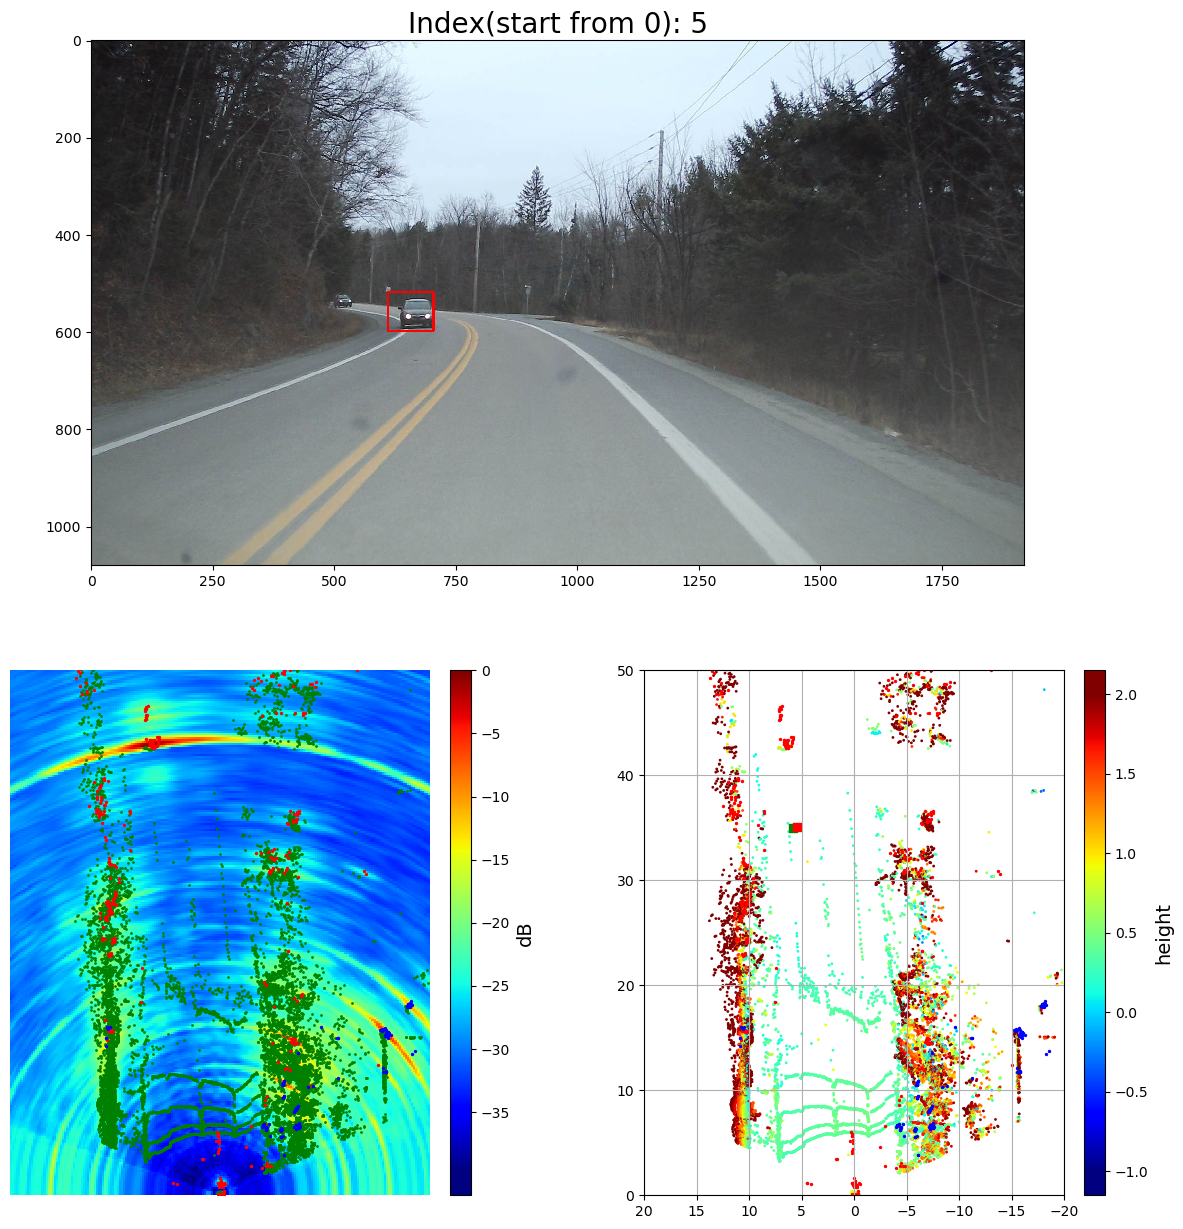

In [13]:
export_fig = True
select_type = 'train'#'val'#'test'
export_percent = 0.1
if select_type=='train':
    current_ids =train_ids #quantity 6231
elif select_type=='val':
    current_ids = val_ids #986
elif select_type=='test':
    current_ids = test_ids #1035
else:
    raise ValueError('false type')          
if export_fig==True:
    export_dir= os.path.join(os.getcwd(),'export_maskandref')
    os.makedirs(export_dir,exist_ok=True)
    export_dir= os.path.join(export_dir,select_type)
    os.makedirs(export_dir,exist_ok=True)

# you need to provide the dbc decoder
can_decoder = CANDecoder('can_database.dbc')
Num_R_Bin = 512
AoA_mat = np.load('CalibrationTable.npy',allow_pickle=True).item()
sin_azi_axis = np.sin(np.deg2rad(AoA_mat['Azimuth_table'])) #deg
r_axis = np.arange(Num_R_Bin)/Num_R_Bin*103.
cellsize = 0.2 #20cm=1 pixel
x_veh_lim = 50
y_veh_lim = 20
RSP_ra = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')
RSP_pc = RadarSignalProcessing('CalibrationTable.npy',method='PC')
# for interpolation
x_veh = np.arange(x_veh_lim,0-cellsize,-cellsize)
y_veh = np.arange(y_veh_lim,-y_veh_lim-cellsize,-cellsize)
y_veh_mesh,x_veh_mesh = np.meshgrid(y_veh,x_veh)
r_veh_mesh = np.sqrt(np.square(x_veh_mesh)+np.square(y_veh_mesh))
sin_azi_veh_mesh = y_veh_mesh/(r_veh_mesh+np.finfo(np.float32).eps)
r_veh_mesh = np.ravel(r_veh_mesh)
sin_azi_veh_mesh = np.ravel(sin_azi_veh_mesh)
# for doppler compenstation
doppler_resolution = 0.1#m/s
num_doppler_bin = 256
posi_doppler_axis = doppler_resolution*np.arange(num_doppler_bin/2)
negi_doppler_axis = -1*doppler_resolution*np.arange(num_doppler_bin/2,0,-1)
doppler_axis_mps = np.concatenate((negi_doppler_axis.reshape(-1,1),posi_doppler_axis.reshape(-1,1)),axis=0)
doppler_axis_mps = doppler_axis_mps.reshape(-1,)
vel_threshold = 1.5 #m/s
#train_ids 6231, val_ids 986, test_ids 1035
#export mask
for idx in range(np.ceil(export_percent*len(current_ids)).astype(int)):
    idx = 5
    trace_name = labels[label_dict[sample_keys[current_ids[idx]]][0],-3] 
    select_idx_in_trace = labels[label_dict[sample_keys[idx]][0],-2]
    root_folder = os.path.join('/home/yi/work/valeo_dataset/RADIal/',trace_name)
    ### Open the dataset
    current_db = SyncReader(root_folder)
    current_data = current_db.GetSensorData(select_idx_in_trace)
    current_timestamp = current_data['radar_ch0']['timestamp']  
    current_odometry = Own_GetMostRecentOdometry(current_db,can_decoder,current_timestamp) # speed,yaw rate, steering wheel angle
    current_radarvelocity = Get_RadarVelocityInVehCS(current_odometry)

    
    ra=RSP_ra.run(current_data['radar_ch0']['data'],current_data['radar_ch1']['data'],current_data['radar_ch2']['data'],current_data['radar_ch3']['data'])
 
    ##RA Cartesian
    F =interp2d(r_axis,sin_azi_axis,ra.T)
    ra_cartesian =[]
    for i in range(len(r_veh_mesh)):
        ra_cartesian.append(F(r_veh_mesh[i],sin_azi_veh_mesh[i]))
    ra_cartesian = np.asarray(ra_cartesian).reshape(y_veh_mesh.shape[0],y_veh_mesh.shape[1]) 
    ra_cartesian = np.fliplr(ra_cartesian)##because x ais is reversed
    #process radar point cloud
    pc=RSP_pc.run(current_data['radar_ch0']['data'],current_data['radar_ch1']['data'],
        current_data['radar_ch2']['data'],current_data['radar_ch3']['data'])
    Az = pc[:,2] 
    R = pc[:,0]
    El = pc[:,3] 
    Do = pc[:,1] 
    #doppler shift
    #0-127|128-255 
    posi_side = np.where(Do<num_doppler_bin/2)[0]
    negi_side = np.where(Do>=num_doppler_bin/2)[0]
    Do_shift = np.copy(Do)
    Do_shift[posi_side]  = Do_shift[posi_side] + num_doppler_bin/2
    Do_shift[negi_side]  = Do_shift[negi_side] - num_doppler_bin/2
    Do_shift = np.array(Do_shift,dtype=int)
  
    moving_sign = np.abs(doppler_axis_mps[Do_shift]*np.cos(El)+ 
        current_radarvelocity[0]*np.cos(Az)+current_radarvelocity[1]*np.sin(Az))> vel_threshold
    doppler_com = (doppler_axis_mps[Do_shift]+ current_radarvelocity[0]*np.cos(Az)
        +current_radarvelocity[1]*np.sin(Az))*moving_sign.astype(int)#approach -,leave +
    #lidar pc
    pts = current_data['scala']['data']
    pts = ConpensateLayerAngle(np.copy(pts),current_data['scala']['sample_number'],lidar_h)[:,:3]


    fig = plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2,2,width_ratios=[1,1],height_ratios=[1,1])
    ##1 img + boundingbox
    ax1 = fig.add_subplot(gs[0,:] )
    ax1.set_title(f'Index(start from 0): {idx}',fontsize=20)
    cam_img = current_data['camera']['data']
    #format as following [Range, Angle, Doppler,laser_X_m,laser_Y_m,laser_Z_m,x1_pix,y1_pix,x2_pix	,y2_pix]
    for idx_bbox in range(len(dataset[idx][3][:,6])):
        cam_img = cv2.rectangle(cam_img, (int(dataset[idx][3][:,6][idx_bbox]) ,int(dataset[idx][3][:,7][idx_bbox])),\
        (int(dataset[idx][3][:,8][idx_bbox]),int(dataset[idx][3][:,9][idx_bbox])), (0, 0, 255), 3)
    ax1.imshow(cam_img[:,:,-1::-1] )
    ##2 radar+lidar
    ax = fig.add_subplot(gs[1,0] )
    ax.set_xlim([y_veh_lim,-y_veh_lim] )
    ax.set_ylim([0,x_veh_lim] )
    ax.set_aspect('equal')
    ra_cartesian_img = ax.imshow(20*np.log10(ra_cartesian/np.max(ra_cartesian)),
        vmax=0,zorder=0,cmap='jet',extent=[-y_veh_lim,y_veh_lim,0,x_veh_lim] )
    ax.set_axis_off()
    #det for lidar and radar
    #lidar
    plt.scatter(pts[:,1],pts[:,0],s=1,color='green',zorder=1)
    #radar
    plt.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),
        R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red',zorder=2)
    plt.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),
        R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue',zorder=2)
    #colorbar for 2.fig
    divider3 = make_axes_locatable(ax)
    cax3 = divider3.append_axes('right',size='5%',pad=0.2)
    cbar3 =plt.colorbar(ra_cartesian_img,cax=cax3,extend='min',extendrect=True)
    cbar3.set_label(label='dB',size=14)

    ##3 radar+lidar detection
    ax2 = fig.add_subplot(gs[1,1] )
    lidardet_scatter=ax2.scatter(pts[:,1],pts[:,0],s=1,c=pts[:,2]+lidar_h,vmin=-1,vmax=2,cmap='jet')#pts: x,y (Veh C.S.)
    ax2.set_aspect('equal')
    ax2.set_xlim([y_veh_lim,-y_veh_lim])
    ax2.set_ylim([0,x_veh_lim])
    ax2.grid()
    ax2.scatter(R[moving_sign==1] *np.sin(Az[moving_sign==1])*np.cos(El[moving_sign==1]),
        R[moving_sign==1]*np.cos(Az[moving_sign==1])*np.cos(El[moving_sign==1]),s=2,color='red')
    ax2.scatter(R[moving_sign==0] *np.sin(Az[moving_sign==0])*np.cos(El[moving_sign==0]),
        R[moving_sign==0]*np.cos(Az[moving_sign==0])*np.cos(El[moving_sign==0]),s=2,color='blue')
    #colorbar for 3.fig
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes('right',size='5%',pad=0.2)
    cbar2 =plt.colorbar(lidardet_scatter,cax=cax2,extend='both',extendrect=True)
    cbar2.set_label(label='height',size=14)
    #obj label from lidar and radar
    ax2.scatter(-dataset[idx][3][:,3] ,dataset[idx][3][:,4],color='green',zorder=1,marker='s')
    ax2.scatter(dataset[idx][3][:,0]*np.sin(np.deg2rad(dataset[idx][3][:,1])),  
        dataset[idx][3][:,0]*np.cos(np.deg2rad(dataset[idx][3][:,1])),color='red',zorder=1,marker='s')    


    if export_fig == True:
        fig.savefig(os.path.join(export_dir,f'reference_{idx:05d}.png'))
    break    

In [68]:
len(test_ids)

1035